In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [2]:
def softmax(x):
    z = x - np.max(x)   # overflow protection (softmax(x) = softmax(x - const))
    return np.exp(z) / np.sum(np.exp(z))

activation_functions = {
    'tanh': np.tanh,
    'relu': (lambda x: np.maximum(0, x)),
    'sigmoid': (lambda x: 1 / (1 + np.exp(-x))),
    'linear': (lambda x: x),
    'softmax': softmax
}

**Loading Data**

In [3]:
%%time
t0 = time.time()
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, np.shape(X_train)[1] * np.shape(X_train)[1]).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, np.shape(X_test)[1] * np.shape(X_test)[1]).astype(np.float32) / 255.0
y_train = to_categorical(y_train)   # one-hot encoding
y_test = to_categorical(y_test)  # one-hot encoding

CPU times: total: 312 ms
Wall time: 319 ms


**Network Definition**

In [4]:
class Layer():
    def __init__(self, weight, connectivity_matrix, bias, activation_function,
                 innovation, enabled, output_layer=False):
        self.weight = weight
        self.connectivity_matrix = connectivity_matrix
        self.bias = bias
        if output_layer:
            assert(activation_function == 'softmax'), 'output layer must use softmax'
        self.activation_function = activation_function
        self.innovation = innovation
        self.enabled = enabled
        self.output_layer = output_layer    # final 10 neuron layer (activation fixed to softmax)

        # TODO: tune
        self.mutate_rate_weight = 0.1
        self.mutate_rate_connections = 0.3
        self.mutate_rate_bias = 0.1
        self.mutate_rate_activation_function = 0.1

    def forward(self, input):
        return activation_functions[self.activation_function](
            self.weight * self.connectivity_matrix @ input + self.bias
        )

    def mutate(self):
        # TODO: correct idea?
        # TODO: quite arbitrary, inefficient and do negative numbers work?

        # weight
        # TODO: change this mess
        weight_bin = bin(self.weight)[2:].zfill(7)   # 7 bit bitstring
        temp = ''
        for i in range(len(weight_bin)):
            if random.uniform(0, 1) < self.mutate_rate_weight:
                temp2 = '0' if weight_bin[i] == '1' else '1'
                temp += temp2
            else:
                temp += weight_bin[i]
        self.weight = int(temp, 2)

        # connectivity matrix
        # TODO: row, col correct?
        for row in range(np.shape(self.connectivity_matrix)[0]):
            for col in range(np.shape(self.connectivity_matrix)[1]):
                if random.uniform(0, 1) < self.mutate_rate_connections:
                    self.connectivity_matrix[row][col] = 1 - self.connectivity_matrix[row][col]

        # bias
        # TODO: change this mess
        bias_bin = bin(self.bias)[2:].zfill(7)  # 7 bit bitstring
        temp = ''
        for i in range(len(bias_bin)):
            if random.uniform(0, 1) < self.mutate_rate_bias:
                temp2 = '0' if bias_bin[i] == '1' else '1'
                temp += temp2
            else:
                temp += bias_bin[i]
        self.bias = int(temp, 2)

        # activation function
        if not self.output_layer:
            if random.uniform(0, 1) < self.mutate_rate_activation_function:
                self.activation_function = random.choice(list(activation_functions.keys()))

In [5]:
class Network():
    def __init__(self, layers):
        self.layers = layers    # structured (feedforward) array of layers

    def forward(self, input):
        temp = input
        for layer in self.layers:
            temp = layer.forward(temp)
        return temp

    def evaluate(self):  # TODO: slow? (on cpu ~0.55s per call)
        accuracy = 0
        for x, y in zip(X_test, y_test):
            y_pred = np.argmax(self.forward(x.reshape(-1)))  # class with highest value
            y_true = np.argmax(y)
            if y_pred == y_true:
                accuracy += 1
        return accuracy / np.shape(X_test)[0]

    def mutate(self):
        for layer in self.layers:
            layer.mutate()
        # TODO: change network mutation (new layers)

In [7]:
class Population():
    def __init__(self, size=10, n_survivors=5):
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors  # TODO: for now must be odd number (1 elite + odd breeders)
        self.elite = None

        # initialization # TODO: better (quite random now - e.g. 32 hidden neurons)
        self.organisms = []
        for i in range(size):
            # one hidden layer (32 neurons), one output layer (10 neurons - 1 resp. to each class)
            self.organisms.append(Network([
                Layer(
                    weight=1,
                    connectivity_matrix=np.round(np.random.rand(32, 784)),
                    bias=0,
                    activation_function='sigmoid',
                    innovation=0,
                    enabled=True,
                    output_layer=False
                ),
                Layer(
                    weight=1,
                    connectivity_matrix=np.round(np.random.rand(32, 32)),
                    bias=0,
                    activation_function='sigmoid',
                    innovation=0,
                    enabled=True,
                    output_layer=False
                ),
                Layer(
                    weight=1,
                    connectivity_matrix=np.round(np.random.rand(32, 32)),
                    bias=0,
                    activation_function='sigmoid',
                    innovation=0,
                    enabled=True,
                    output_layer=False
                ),
                Layer(
                    weight=1,
                    connectivity_matrix=np.round(np.random.rand(32, 32)),
                    bias=0,
                    activation_function='sigmoid',
                    innovation=0,
                    enabled=True,
                    output_layer=False
                ),
                Layer(
                    weight=1,
                    connectivity_matrix=np.round(np.random.rand(10, 32)),
                    bias=0,
                    activation_function='softmax',
                    innovation=0,
                    enabled=True,
                    output_layer=True
                )
            ]))

        self.history = [(max(self.organism_fitness()), self.average_fitness())]   # fitness of population over all generations

    def organism_fitness(self):
        # TODO: speciation
        return [organism.evaluate() for organism in self.organisms]

    def average_fitness(self):
        # TODO: speciation
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        # TODO: speciation
        return max(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)    # TODO: works without replacement and p?
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        # TODO: for different type of networks
        # TODO: correct?
        children = []
        while len(children) < (self.size - 1):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement
            layers = []

            # TODO: for now assume same no of layers
            for father_gene, mother_gene in zip(father.layers, mother.layers):
                # full gene crossover # TODO: correct?
                child_weight = father_gene.weight if (random.uniform(0, 1) < 0.5) else mother_gene.weight
                child_bias = father_gene.bias if (random.uniform(0, 1) < 0.5) else mother_gene.bias
                child_activation_function = father_gene.activation_function if \
                    (random.uniform(0, 1) < 0.5) else mother_gene.activation_function

                # uniform (bit-wise) crossover # TODO: correct?
                child_connectivity_matrix = np.zeros(np.shape(father_gene.connectivity_matrix))
                for row in range(np.shape(child_connectivity_matrix)[0]):
                    for col in range(np.shape(child_connectivity_matrix)[1]):
                        child_connectivity_matrix[row][col] = father_gene.connectivity_matrix[row][col] \
                            if (random.uniform(0, 1) < 0.5) else mother_gene.connectivity_matrix[row][col]

                layers.append(Layer(
                    weight=child_weight,
                    connectivity_matrix=child_connectivity_matrix,
                    bias=child_bias,
                    activation_function=child_activation_function,
                    innovation=0,
                    enabled=True
                ))

            children.append(Network(layers))

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self):
        t = time.time()
        parents = self.selection()
        print('selection time: {}s'.format(round(time.time() - t, 3)))
        t = time.time()
        children = self.crossover(parents)
        print('crossover time: {}s'.format(round(time.time() - t, 3)))
        t = time.time()
        '''print('pre mutation', [child.evaluate() for child in children], 'elite', self.elite.evaluate())
        self.mutate(children)
        print('after mutation', [child.evaluate() for child in children], 'elite', self.elite.evaluate())
        weights = '['
        for organims in (children + [self.elite]):
            weights += str(organims.layers[0].weight) + ', '
        print(weights + ']')'''
        self.organisms = children + [self.elite]
        self.generation += 1
        self.history.append((self.max_fitness(), self.average_fitness()))

    def plot(self):
        plt.figure()
        plt.plot(np.arange(self.generation + 1), [score[0] for score in self.history],
                 label='max fitness')
        plt.plot(np.arange(self.generation + 1), [score[1] for score in self.history],
                 label='avg fitness', alpha=0.6)
        plt.title('Population fitness')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()
        plt.show()

**Training**

In [8]:
# initialization
GENERATIONS = 50
POPULATION_SIZE = 10
SURVIVORS = 5
population = Population(size=POPULATION_SIZE, n_survivors=SURVIVORS)

Starting training
Gen 0 : [0.098, 0.1135, 0.1032, 0.0958, 0.101, 0.0892, 0.0982, 0.0892, 0.0974, 0.1032] - max: 0.1135 (29.68s)
selection time: 14.732s
crossover time: 0.232s
evaluation time: 29.648s
Gen 1 : [0.0974, 0.1032, 0.1032, 0.0974, 0.1135, 0.098, 0.0974, 0.1028, 0.1135, 0.1135] - max: 0.1135 (74.31s)
selection time: 14.954s
crossover time: 0.21s
evaluation time: 29.482s
Gen 2 : [0.1135, 0.0982, 0.1135, 0.098, 0.1028, 0.0974, 0.0974, 0.0974, 0.1028, 0.1135] - max: 0.1135 (74.43s)
selection time: 14.678s
crossover time: 0.218s
evaluation time: 29.529s
Gen 3 : [0.101, 0.1028, 0.0974, 0.1135, 0.0982, 0.1028, 0.0974, 0.0974, 0.098, 0.1135] - max: 0.1135 (73.81s)
selection time: 14.678s
crossover time: 0.225s
evaluation time: 29.398s
Gen 4 : [0.0982, 0.098, 0.1028, 0.1028, 0.1135, 0.1032, 0.1028, 0.101, 0.1028, 0.1135] - max: 0.1135 (73.76s)
selection time: 14.644s
crossover time: 0.222s
evaluation time: 29.286s
Gen 5 : [0.101, 0.0974, 0.1028, 0.1028, 0.1028, 0.1028, 0.0982, 0.1028,

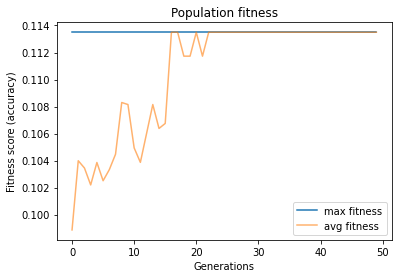

In [9]:
# initial population
print('Starting training')
t_training = time.time()
population_fitness = population.organism_fitness()
max_fitness = population.max_fitness()
t2 = time.time()
print('Gen', 0, ':',
      population_fitness, '- max:',
      max_fitness,
      '({}s)'.format(round(t2 - t_training, 2)))

# future populations
for generation in range(1, GENERATIONS):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    ta=time.time()
    population_fitness = population.organism_fitness()
    max_fitness = population.max_fitness()
    print('evaluation time: {}s'.format(round(time.time() - ta, 3)))
    t2 = time.time()

    print('Gen', generation, ':',
          population_fitness, '- max:',
          max_fitness,
          '({}s)'.format(round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))
print('\nTotal computation time: ({}s)'.format(round(time.time() - t0, 2)))

# performance of population
population.plot()